# Template PIV Post

In [1]:
import h5rdmtoolbox as h5tbx
import pathlib
import numpy as np
_ = h5tbx.set_config(add_provenance=False)

## Stats

Find out what the PIV method is, the final window size, etc

In [2]:
from standardpostpiv import badge, StandardPIVResult
from standardpostpiv.flags import eval_flags

Initialize a helper class around the PIV result HDF5 file:

In [3]:
res = StandardPIVResult('z+35/dpiv_mgrid24-3-50/dpiv_mgrid24-3-50.hdf')

Compute the valid detection probability (VDP):

In [4]:
flag_series = eval_flags(res.piv_flags[()])
edited_vectors = np.sum([flag_series[f] for f in ('NORESULT', 'FILTERED', 'INTERPOLATED', 'REPLACED', 'MANUALEDIT')], axis=0)
vdp = (flag_series['ACTIVE']-edited_vectors)/flag_series['ACTIVE']
vdp['standard_name'] = 'valid_detection_probability'
vdp.name = 'vdp'
vdp.attrs['units'] = ''

Get a broad overview of the file:

In [5]:
def to_quantity(da):
    if da.ndim == 0:
        return h5tbx.get_ureg().Quantity(da.data, units=da.units)
        
badge.display(method=res.eval_method,
              final_ws=res.final_iw_size,
              piv_dim=res.piv_dim,
              piv_type=res.piv_type,
              magnification=str(to_quantity(res.piv_scaling_factor[()])),
              vdp=f'{np.mean(vdp):.2f}',
              color=['green', 'blue', 'yellow', None, 'orange'], inline=True)

![nbviewer](https://img.shields.io/badge/method-multi_grid-green.svg) ![nbviewer](https://img.shields.io/badge/final_ws-(24,_24)-blue.svg) ![nbviewer](https://img.shields.io/badge/piv_dim-2D2C-yellow.svg) ![nbviewer](https://img.shields.io/badge/piv_type-plane-None.svg) ![nbviewer](https://img.shields.io/badge/magnification-8520.0_pixel/m-orange.svg) ![nbviewer](https://img.shields.io/badge/vdp-1.00-lightgray.svg)

In [6]:
import standardpostpiv.plotting as stdplt

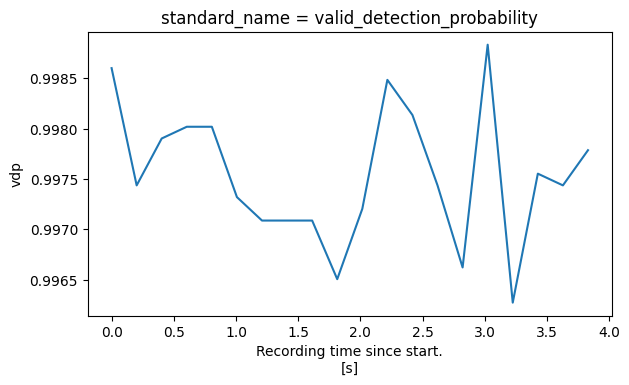

In [7]:
fig, axes = stdplt.subplots(1, 1, tight_layout=True)
vdp.plot(ax=axes)

In [47]:
from standardpostpiv.utils import apply_mask

In [64]:
dx = apply_mask(res.x_displacement[()],
                res.piv_flags[()],
                2)
dy = apply_mask(res.y_displacement[()],
                res.piv_flags[()],
                2)

# PDFs

In [74]:
bins_per_pixel = 10

In [75]:
dx = dx.where(dx>-7)
dx = dx.where(dx<3)

dy = dy.where(0<dy)
dy = dy.where(dy<15)

In [76]:
dx_subpx = dx[0,:,:]-dx[0,:,:].astype(int)
dy_subpx = dy[0,:,:]-dy[0,:,:].astype(int)

dx_subpx = dx_subpx.where(dx_subpx<0.5, dx_subpx-1).where(dx_subpx>-0.5, dx_subpx+1)
dx_subpx.attrs['standard_name'] = 'x_sub_pixel_displacement'
dy_subpx = dy_subpx.where(dy_subpx<0.5, dy_subpx-1).where(dy_subpx>-0.5, dy_subpx+1)
dy_subpx.attrs['standard_name'] = 'y_sub_pixel_displacement'

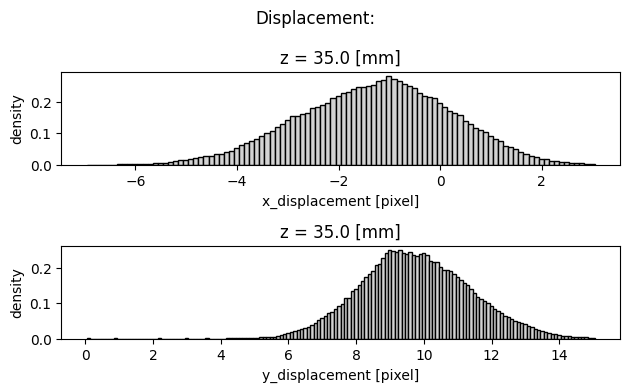

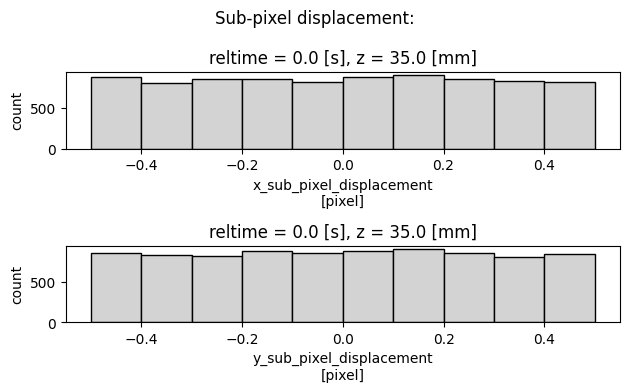

In [77]:
fig, axes = stdplt.subplots(2, 1, tight_layout=True)
fig.suptitle('Displacement:')
_ = dx.plot.hist(binwidth=1/bins_per_pixel, density=True, ax=axes[0])  # 10 bins per pixel
_ = dy.plot.hist(binwidth=1/bins_per_pixel, density=True, ax=axes[1])  # 10 bins per pixel
# axes[0].plot_normal_distribution(dx, n=100)
# axes[1].plot_normal_distribution(dy, n=100)

fig, axes = stdplt.subplots(2, 1, tight_layout=True)
fig.suptitle('Sub-pixel displacement:')
_ = dx_subpx.plot.hist(binwidth=1/bins_per_pixel, ax=axes[0])
_ = dy_subpx.plot.hist(binwidth=1/bins_per_pixel, ax=axes[1])

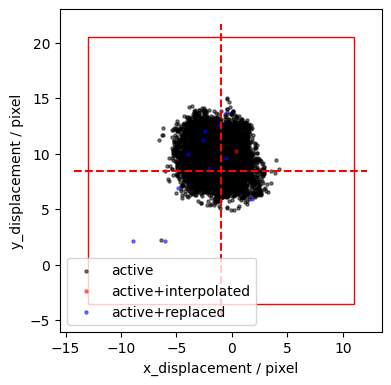

In [69]:
stdplt.piv_scatter(res.x_displacement[0, ...],
                   res.y_displacement[0, ...],
                   flags=res.piv_flags[0, ...],
                   fiwsize=res.final_iw_size)
stdplt.legend(loc='lower left')

## Velocity fields

In [14]:
from standardpostpiv.utils import compute_magnitude
import xarray as xr

In [15]:
displacement_magnitude = xr.concat([compute_magnitude(dx[i,...], dy[i,...]) for i in range(dx.coords['reltime'].size)], 'reltime')
displacement_magnitude.attrs['standard_name'] = 'magnitude_of_displacement'

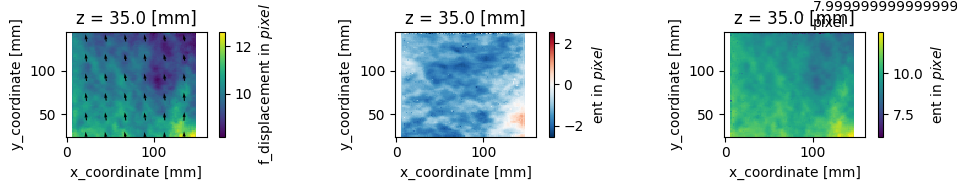

In [16]:
fig, axes = stdplt.subplots(1, 3, figsize=(10, 2), tight_layout=True)
displacement_magnitude.stdpiv.mean('reltime').plot(ax=axes[0])
# axes.pivstreamplot(dx.mean('reltime')[:,:], dy.mean('reltime')[:,:], color='k')
axes[0].pivquiver(dx.mean('reltime')[:,:], dy.mean('reltime')[:,:], color='k', every=16)

dx.stdpiv.mean('reltime').plot(ax=axes[1])
dy.stdpiv.mean('reltime').plot(ax=axes[2])
for ax in axes:
    ax.set_aspect('equal')

### Monitor points - velocity

In [17]:
n_pts = 4
mp_x = np.random.uniform(low=res.x_coordinate[0], high=res.x_coordinate[-1], size=4)
mp_y = np.random.uniform(low=res.y_coordinate[0], high=res.y_coordinate[-1], size=4)

In [18]:
from standardpostpiv.utils import MaskSeeder

In [19]:
# random seed:
monitor_points = MaskSeeder(res.get_mask()[0,:,:],
                            res.x_coordinate,
                            res.y_coordinate,
                            n=4, min_dist=20).generate(ret_indices=False)
# manually:
# monitor_points = [(130, 100, 20, 50), (25, 30.5, 100, 200)]

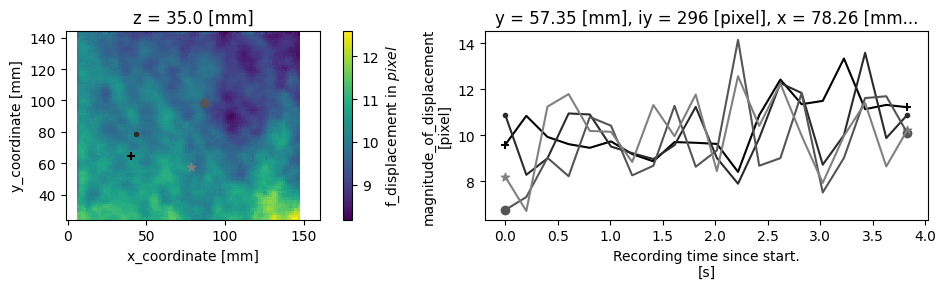

In [20]:
fig, axes = stdplt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
displacement_magnitude.stdpiv.mean('reltime').plot(ax=axes[0])
axes[0].set_aspect(1)

for x, y in monitor_points:
    m, c = next(stdplt.markers), next(stdplt.gray_colors)
    monitor_pt = displacement_magnitude.sel(x=x, y=y)
    line = monitor_pt.plot(ax=axes[1], marker='', color=c)
    # mark first and last point:
    axes[1].scatter(monitor_pt.reltime[0], monitor_pt[0], marker=m, color=line[0].get_color())
    axes[1].scatter(monitor_pt.reltime[-1], monitor_pt[-1], marker=m, color=line[0].get_color())
    axes[0].scatter(monitor_pt.x, monitor_pt.y, marker=m, color=line[0].get_color())

### Monitor points - convergence

Convergence or "significance" is judged by analyzing the evolution the running standard deviation $\sigma_r$ in relation to the running mean $\mu_r$:
\begin{equation}
    s = \frac{\sigma_r}{\mu_r}
\end{equation}

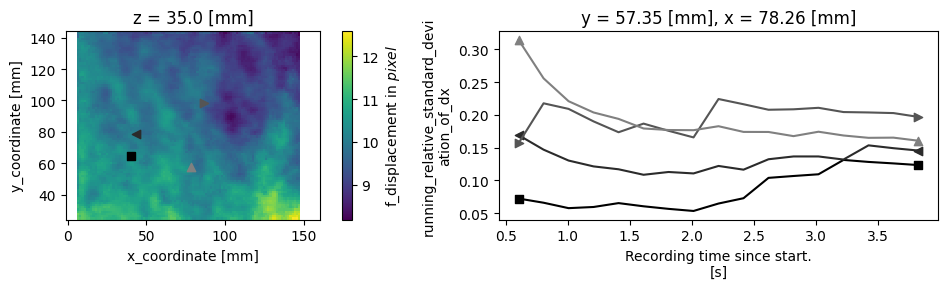

In [21]:
fig, axes = stdplt.subplots(1, 2, figsize=(10, 3), tight_layout=True)
displacement_magnitude.stdpiv.mean('reltime').plot(ax=axes[0])
axes[0].set_aspect(1)

ddof = 2

rrsd = displacement_magnitude.stdpiv.compute_running_relative_standard_deviation(dim='reltime', ddof=ddof)

for x, y in monitor_points:
    m, c = next(stdplt.markers), next(stdplt.gray_colors)
    monitor_rrsd = rrsd.sel(x=x, y=y, method='nearest')
    line = monitor_rrsd.plot(color=c)
    axes[1].scatter(monitor_rrsd.reltime[ddof+1], monitor_rrsd[ddof+1], marker=m, color=line[0].get_color())
    axes[1].scatter(monitor_rrsd.reltime[-1], monitor_rrsd[-1], marker=m, color=line[0].get_color())
    axes[0].scatter(monitor_rrsd.x, monitor_rrsd.y, marker=m, color=line[0].get_color())

### Monitor - line data

C:\Users\da4323\Anaconda3\envs\opencefadb\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


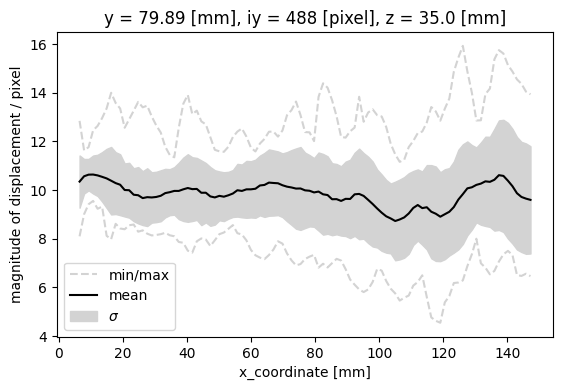

In [22]:
fig, axes = stdplt.subplots(1, 1)

mean_abs_displacement = displacement_magnitude.sel(y=80, method='nearest').mean('reltime')
max_abs_displacement = displacement_magnitude.sel(y=80, method='nearest').max('reltime')
min_abs_displacement = displacement_magnitude.sel(y=80, method='nearest').min('reltime')
std_abs_displacement = displacement_magnitude.sel(y=80, method='nearest').std('reltime')

max_abs_displacement.plot(ax=axes, linestyle='--', label='min/max', color='lightgray')
min_abs_displacement.plot(ax=axes, linestyle='--', color='lightgray')
mean_abs_displacement.plot(ax=axes, label='mean', color='k')

axes.fill_between(mean_abs_displacement.x,
                  (mean_abs_displacement-std_abs_displacement), (mean_abs_displacement+std_abs_displacement),
                 color='lightgray', label='$\sigma$')

axes.set_ylabel('magnitude of displacement / pixel')
stdplt.legend()